In [ ]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage import map_coordinates, gaussian_filter
from sklearn.metrics import precision_recall_fscore_support
import shutil

%run '/kaggle/input/cte-moreparams/Transformer_CustomEncoder_final_pe_modecombinedpart2.ipynb'
%run '/kaggle/input/cte-moreparams/dataloader_imreshape_change.ipynb'

import numpy as np
import os

torch.Size([1, 105])


In [ ]:
class LabelSomCE(nn.Module):
	def __init__(self):
		super().__init__()

	def forward(self,x,target,smoothing=0.1):
		confidence = 1.0 - smoothing
		logprobs = F.log_softmax(x,dim=-1)
		nll_loss = - logprobs.gather(dim=-1,index=target.unsqueeze(1))
		nll_loss = nll_loss.squeeze(1)
		smooth_loss = -logprobs.mean(dim=-1)
		loss = confidence * nll_loss + smoothing * smooth_loss

		return loss.mean()

def download(folder,thetarfile):
    import urllib.request
    import tarfile
    ftpstream = urllib.request.urlopen(thetarfile)
    thetarfile = tarfile.open(fileobj=ftpstream, mode="r|gz")
    thetarfile.extractall(folder)
    thetarfile.close()

def extract_local_tar(local_tar_path, folder):
    with tarfile.open(local_tar_path, 'r|gz') as tar:
        tar.extractall(path=folder)

def download_cerug(folder):
    local_tarfile = "/CERUG-EN-train-images.tar.gz"
    extract_local_tar(local_tarfile, folder)
    #thetarfile = "https://www.ai.rug.nl/~sheng/writerset/CERUG-EN-train-images.tar.gz"
    #download(folder,thetarfile)
    local_tarfile = "/CERUG-EN-test-images.tar.gz"
    extract_local_tar(local_tarfile, folder)
    #thetarfile = "https://www.ai.rug.nl/~sheng/writerset/CERUG-EN-test-images.tar.gz"
    #download(folder,thetarfile)

def download_firemaker(folder):
    thetarfile = "https://www.ai.rug.nl/~sheng/writerset/Firemaker-train-images.tar.gz"
    download(folder,thetarfile)
    thetarfile = "https://www.ai.rug.nl/~sheng/writerset/Firemaker-test-images.tar.gz"
    download(folder,thetarfile)

def copy_folder_contents(source_folder, destination_folder):
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)
    for item in os.listdir(source_folder):
        source_path = os.path.join(source_folder, item)
        destination_path = os.path.join(destination_folder, item)
        if os.path.isdir(source_path):
            shutil.copytree(source_path, destination_path)
        else:
            shutil.copy2(source_path, destination_path)


In [ ]:
class ImageTransformer:
    def __init__(self, foldername, imgtype='png'):
        self.imgtype = imgtype
        self.folder = foldername
        self.imglist = self.get_imgList(self.folder)
        print(f'Image list: {self.imglist}')
        print(f'Number of images: {len(self.imglist)}')

    def get_imgList(self, folder):
        return [img for img in os.listdir(folder) if img.endswith(self.imgtype)]

    def elastic_transform(self, image, alpha, sigma):
        random_state = np.random.RandomState(None)
        shape = image.shape

        dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
        dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha

        x, y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), indexing='ij')
        indices = np.reshape(x + dx, (-1, 1)), np.reshape(y + dy, (-1, 1))

        distorted_image = map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)
        return distorted_image

    def perspective_transform(self, image):
        width, height = image.size
        coeffs = self.find_coeffs(
            [(0, 0), (width, 0), (width, height), (0, height)],
            [(random.randint(0, width // 4), random.randint(0, height // 4)),
             (width - random.randint(0, width // 4), random.randint(0, height // 4)),
             (width - random.randint(0, width // 4), height - random.randint(0, height // 4)),
             (random.randint(0, width // 4), height - random.randint(0, height // 4))]
        )
        return image.transform((width, height), Image.PERSPECTIVE, coeffs, Image.BICUBIC)

    def find_coeffs(self, pa, pb):
        matrix = []
        for p1, p2 in zip(pa, pb):
            matrix.append([p1[0], p1[1], 1, 0, 0, 0, -p2[0] * p1[0], -p2[0] * p1[1]])
            matrix.append([0, 0, 0, p1[0], p1[1], 1, -p2[1] * p1[0], -p2[1] * p1[1]])

        A = np.matrix(matrix, dtype=float)
        B = np.array(pb).reshape(8)

        res = np.dot(np.linalg.inv(A.T * A) * A.T, B)
        return np.array(res).reshape(8)

    def process_and_save_images(self):
        for imgfile in self.imglist:
            # Open the image
            image = Image.open(os.path.join(self.folder, imgfile)).convert('L')
            original_image = np.array(image)

            # Save original image
            original_image_filename = os.path.join(self.folder, imgfile)
            image.save(original_image_filename)

            # Elastic distortion
            elastic_image = self.elastic_transform(original_image, alpha=34, sigma=4)
            elastic_image = Image.fromarray(elastic_image).convert('L')
            elastic_image_filename = os.path.join(self.folder, imgfile.split('.')[0] + '_1.' + self.imgtype)
            elastic_image.save(elastic_image_filename)

            # Perspective transformation
            perspective_image = self.perspective_transform(image)
            perspective_image_filename = os.path.join(self.folder, imgfile.split('.')[0] + '_2.' + self.imgtype)
            perspective_image.save(perspective_image_filename)

Image list: ['Writer5656_03-01-line-0-n-0-y-47-x-65-h-107-w-142.png', 'Writer1414_03-01-line-2-n-10-y-373-x-1647-h-92-w-125.png', 'Writer4646_03-01-line-2-n-5-y-338-x-1472-h-94-w-248.png', 'Writer9105_03-01-line-1-n-5-y-214-x-1269-h-96-w-312.png', 'Writer5656_03-01-line-1-n-5-y-209-x-1426-h-106-w-116.png', 'Writer3636_03-01-line-4-n-8-y-682-x-1590-h-108-w-300.png', 'Writer4040_03-01-line-1-n-5-y-167-x-1878-h-128-w-344.png', 'Writer3232_03-01-line-0-n-4-y-39-x-918-h-87-w-155.png', 'Writer3131_03-01-line-2-n-7-y-341-x-1769-h-113-w-146.png', 'Writer6464_03-01-line-3-n-6-y-541-x-1184-h-95-w-111.png', 'Writer2828_03-01-line-0-n-3-y-47-x-786-h-101-w-199.png', 'Writer6161_03-01-line-0-n-6-y-46-x-1496-h-119-w-120.png', 'Writer2020_03-01-line-3-n-4-y-957-x-871-h-109-w-238.png', 'Writer9105_03-01-line-5-n-2-y-839-x-644-h-86-w-282.png', 'Writer1010_03-01-line-0-n-8-y-48-x-1819-h-120-w-146.png', 'Writer5353_03-01-line-0-n-1-y-28-x-236-h-101-w-251.png', 'Writer4343_03-01-line-2-n-0-y-367-x-439-h-90

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_24/854556313.py:155: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/854556313.py:158: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*1

Testing epoch: 0   avg testing loss is: 3.460772775043951
Testing on epoch: 0 has accuracy: top1: 26.51 top5: 64.58
Precision: 36.87%, Recall: 26.29%, F1 Score: 21.48%


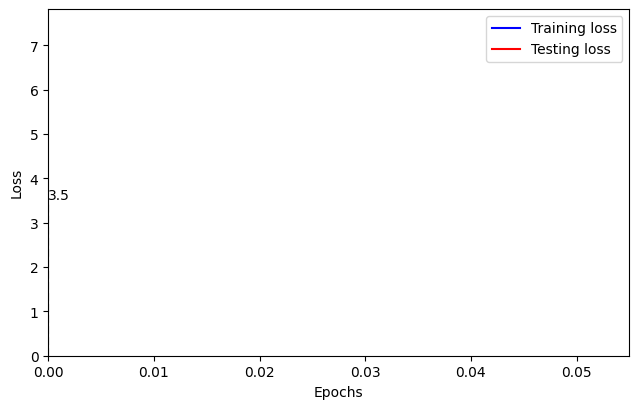

Traing epoch: 1   avg loss is: 4.718614755778585


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_24/854556313.py:155: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/854556313.py:158: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*1

Testing epoch: 1   avg testing loss is: 3.6471062345296796
Testing on epoch: 1 has accuracy: top1: 30.25 top5: 63.25
Precision: 39.78%, Recall: 30.49%, F1 Score: 25.14%


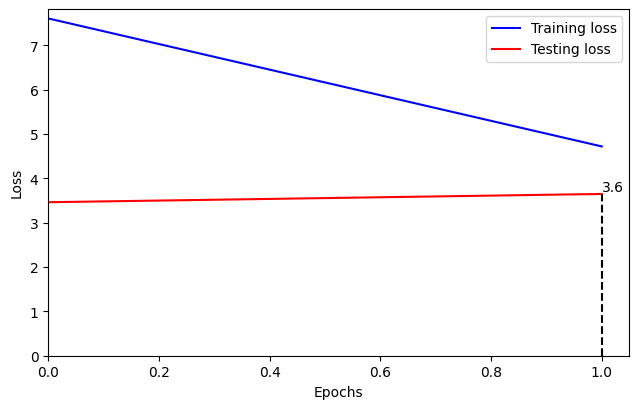

Traing epoch: 2   avg loss is: 3.486630371065202


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_24/854556313.py:155: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/854556313.py:158: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*1

Testing epoch: 2   avg testing loss is: 3.3275579232664496
Testing on epoch: 2 has accuracy: top1: 29.53 top5: 68.66
Precision: 46.37%, Recall: 29.59%, F1 Score: 27.72%


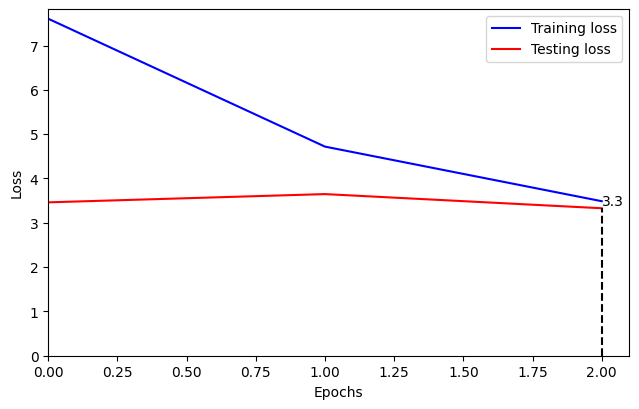

Traing epoch: 3   avg loss is: 2.778061765058783


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_24/854556313.py:155: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/854556313.py:158: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*1

Testing epoch: 3   avg testing loss is: 2.552581099334907
Testing on epoch: 3 has accuracy: top1: 48.37 top5: 82.82
Precision: 65.60%, Recall: 48.30%, F1 Score: 46.63%


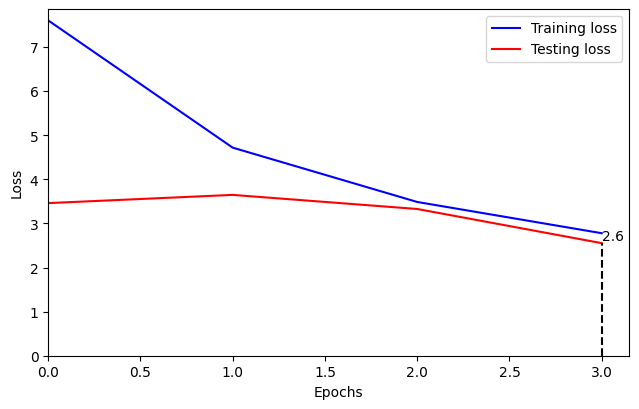

Traing epoch: 4   avg loss is: 2.382201976481724


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_24/854556313.py:155: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/854556313.py:158: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*1

Testing epoch: 4   avg testing loss is: 2.673424873396615
Testing on epoch: 4 has accuracy: top1: 46.15 top5: 79.99
Precision: 58.95%, Recall: 46.51%, F1 Score: 42.60%


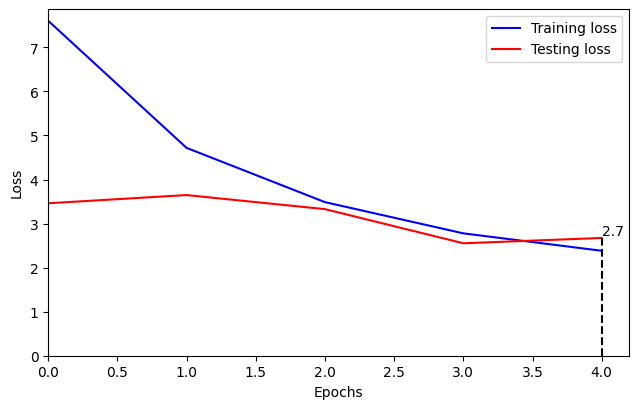

Traing epoch: 5   avg loss is: 2.150989608746806


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_24/854556313.py:155: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/854556313.py:158: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*1

Testing epoch: 5   avg testing loss is: 3.5751983391533018
Testing on epoch: 5 has accuracy: top1: 38.64 top5: 66.73
Precision: 55.11%, Recall: 38.60%, F1 Score: 34.85%


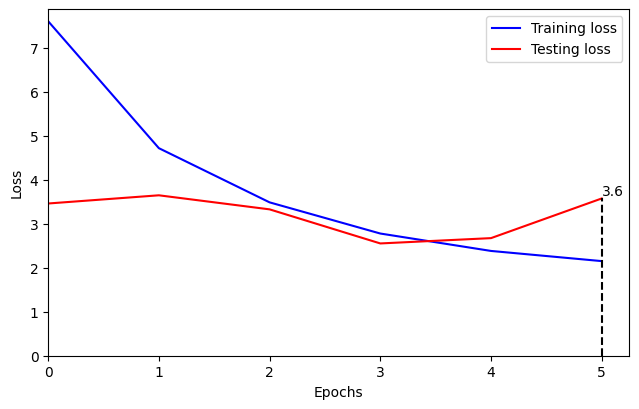

Traing epoch: 6   avg loss is: 1.9928033906126603


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_24/854556313.py:155: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/854556313.py:158: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*1

Testing epoch: 6   avg testing loss is: 2.204936469084006
Testing on epoch: 6 has accuracy: top1: 57.07 top5: 89.55
Precision: 71.39%, Recall: 57.29%, F1 Score: 56.89%


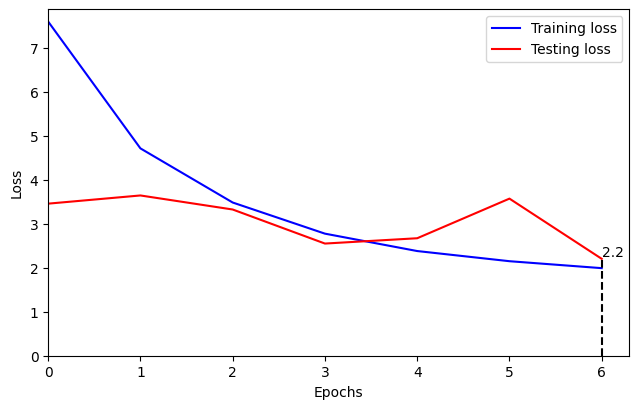

Traing epoch: 7   avg loss is: 1.8500308496468083
Testing epoch: 7   avg testing loss is: 1.8941318676850507
Testing on epoch: 7 has accuracy: top1: 67.58 top5: 93.68
Precision: 77.36%, Recall: 67.79%, F1 Score: 67.30%


/tmp/ipykernel_24/854556313.py:155: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/854556313.py:158: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


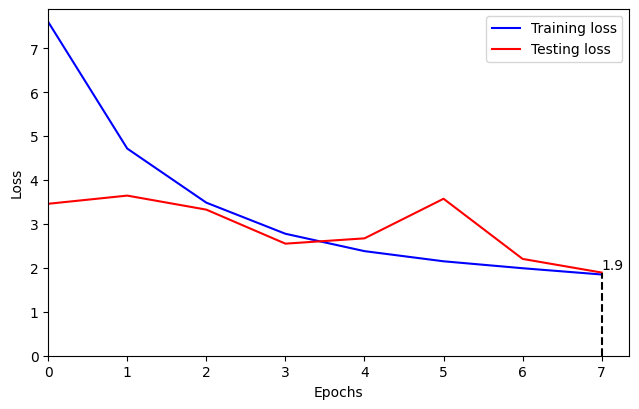

Traing epoch: 8   avg loss is: 1.7350307895938741


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_24/854556313.py:155: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/854556313.py:158: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*1

Testing epoch: 8   avg testing loss is: 1.8967959583734055
Testing on epoch: 8 has accuracy: top1: 68.32 top5: 93.54
Precision: 77.00%, Recall: 68.62%, F1 Score: 67.71%


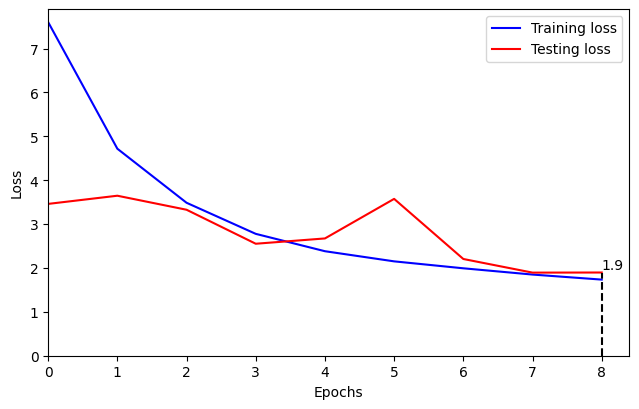

Traing epoch: 9   avg loss is: 1.6490230339503489


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_24/854556313.py:155: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/854556313.py:158: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*1

Testing epoch: 9   avg testing loss is: 3.022672414779663
Testing on epoch: 9 has accuracy: top1: 47.26 top5: 75.37
Precision: 64.38%, Recall: 47.25%, F1 Score: 43.93%


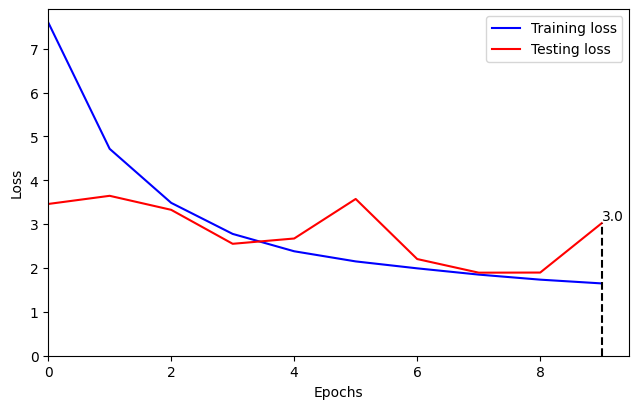

Traing epoch: 10   avg loss is: 1.3877053410233016
Testing epoch: 10   avg testing loss is: 1.6773280948864708
Testing on epoch: 10 has accuracy: top1: 74.08 top5: 95.61
Precision: 81.07%, Recall: 74.20%, F1 Score: 74.11%


/tmp/ipykernel_24/854556313.py:155: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/854556313.py:158: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


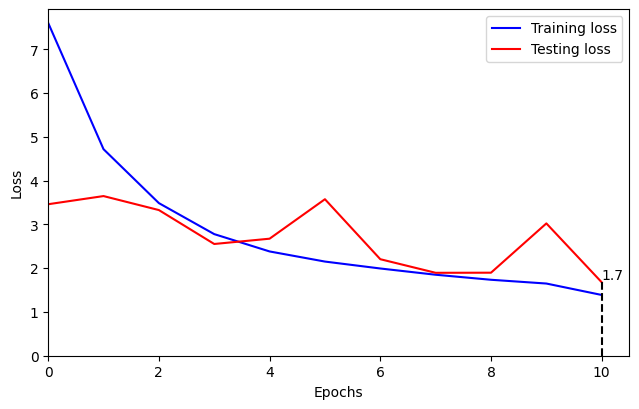

Traing epoch: 11   avg loss is: 1.3341253535339384
Testing epoch: 11   avg testing loss is: 1.657873768672765
Testing on epoch: 11 has accuracy: top1: 74.90 top5: 95.71
Precision: 80.93%, Recall: 75.09%, F1 Score: 74.55%


/tmp/ipykernel_24/854556313.py:155: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/854556313.py:158: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


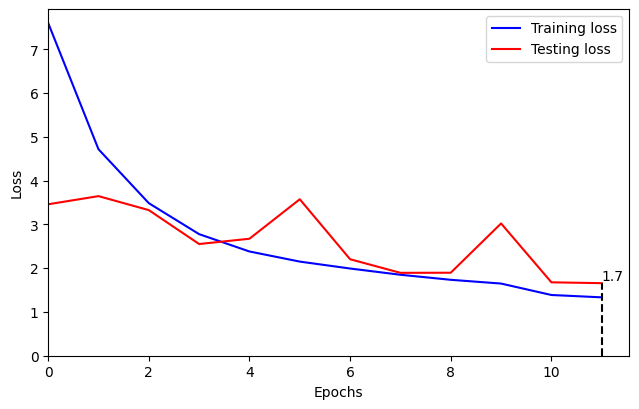

Traing epoch: 12   avg loss is: 1.3039822161364933
Testing epoch: 12   avg testing loss is: 1.541992577808297
Testing on epoch: 12 has accuracy: top1: 79.83 top5: 96.78
Precision: 83.85%, Recall: 79.97%, F1 Score: 79.76%


/tmp/ipykernel_24/854556313.py:155: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/854556313.py:158: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


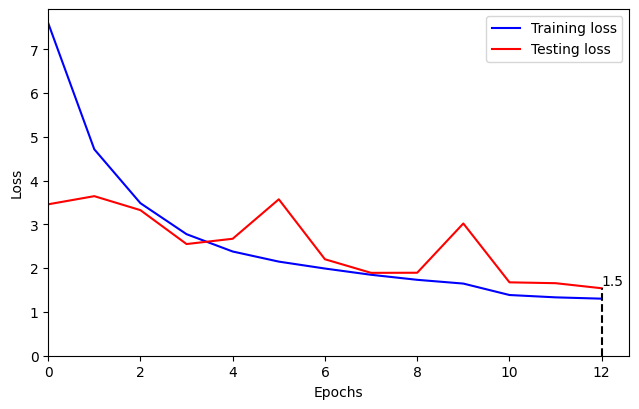

Traing epoch: 13   avg loss is: 1.2740038751552214


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_24/854556313.py:155: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/854556313.py:158: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*1

Testing epoch: 13   avg testing loss is: 1.9334332345059355
Testing on epoch: 13 has accuracy: top1: 67.82 top5: 91.91
Precision: 77.64%, Recall: 67.88%, F1 Score: 67.46%


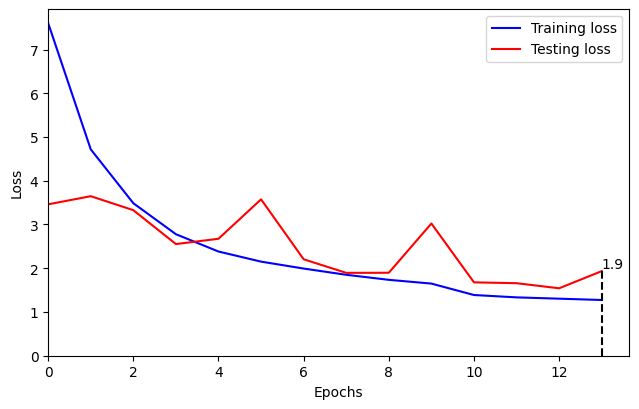

Traing epoch: 14   avg loss is: 1.2371995495902366
Testing epoch: 14   avg testing loss is: 1.702982837908736
Testing on epoch: 14 has accuracy: top1: 74.16 top5: 94.03
Precision: 81.26%, Recall: 74.04%, F1 Score: 73.62%


/tmp/ipykernel_24/854556313.py:155: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/854556313.py:158: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


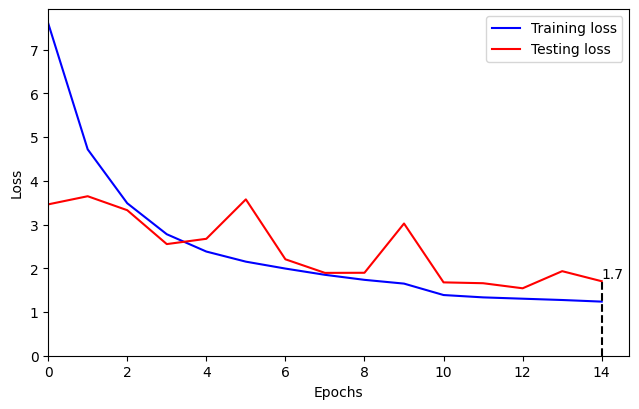

Traing epoch: 15   avg loss is: 1.2018046244156484
Testing epoch: 15   avg testing loss is: 1.5253171456565737
Testing on epoch: 15 has accuracy: top1: 80.55 top5: 96.55
Precision: 84.49%, Recall: 80.52%, F1 Score: 80.47%


/tmp/ipykernel_24/854556313.py:155: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/854556313.py:158: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


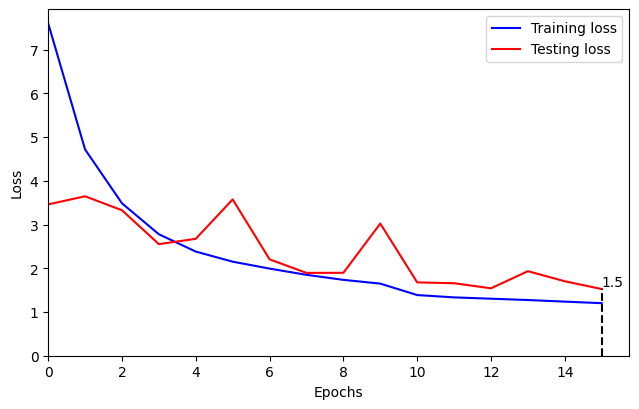

Traing epoch: 16   avg loss is: 1.1735361466572818
Testing epoch: 16   avg testing loss is: 1.71464865787007
Testing on epoch: 16 has accuracy: top1: 73.53 top5: 94.07
Precision: 80.99%, Recall: 74.02%, F1 Score: 72.94%


/tmp/ipykernel_24/854556313.py:155: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/854556313.py:158: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


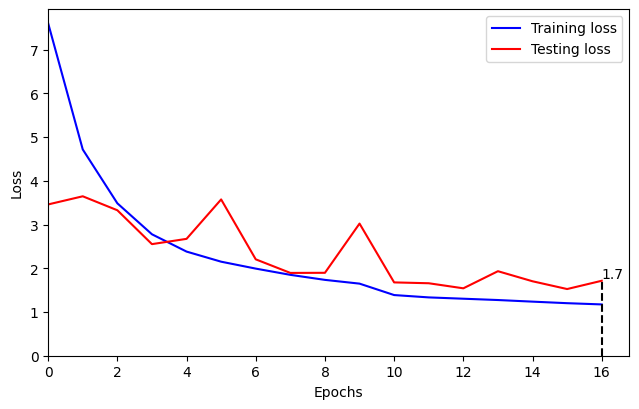

Traing epoch: 17   avg loss is: 1.147987541692964
Testing epoch: 17   avg testing loss is: 1.5111614361730321
Testing on epoch: 17 has accuracy: top1: 80.36 top5: 96.80
Precision: 83.59%, Recall: 80.57%, F1 Score: 80.33%


/tmp/ipykernel_24/854556313.py:155: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/854556313.py:158: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


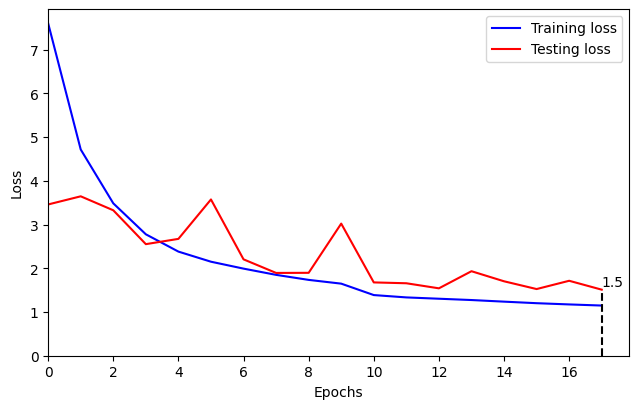

Traing epoch: 18   avg loss is: 1.1298954451162198
Testing epoch: 18   avg testing loss is: 1.8026942527182748
Testing on epoch: 18 has accuracy: top1: 69.98 top5: 92.74
Precision: 78.85%, Recall: 70.21%, F1 Score: 69.52%


/tmp/ipykernel_24/854556313.py:155: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/854556313.py:158: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


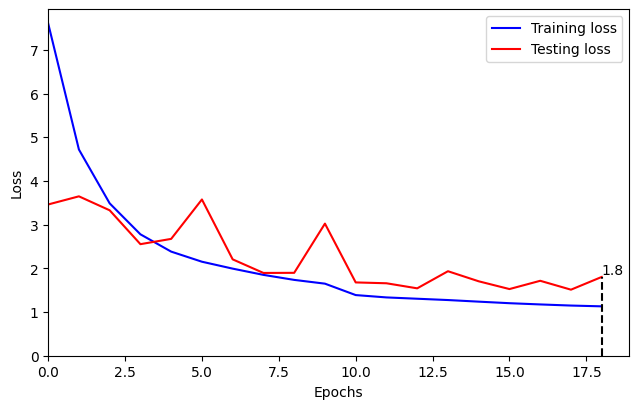

Traing epoch: 19   avg loss is: 1.1085966746309743
Testing epoch: 19   avg testing loss is: 1.7650120343746054
Testing on epoch: 19 has accuracy: top1: 71.89 top5: 92.43
Precision: 80.43%, Recall: 72.21%, F1 Score: 70.91%


/tmp/ipykernel_24/854556313.py:155: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/854556313.py:158: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


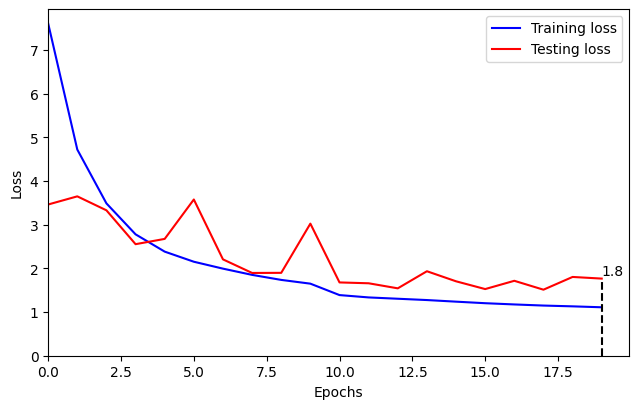

Traing epoch: 20   avg loss is: 1.0236822529526042
Testing epoch: 20   avg testing loss is: 1.4139426864938944
Testing on epoch: 20 has accuracy: top1: 83.11 top5: 96.94
Precision: 85.53%, Recall: 83.25%, F1 Score: 83.07%


/tmp/ipykernel_24/854556313.py:155: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/854556313.py:158: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


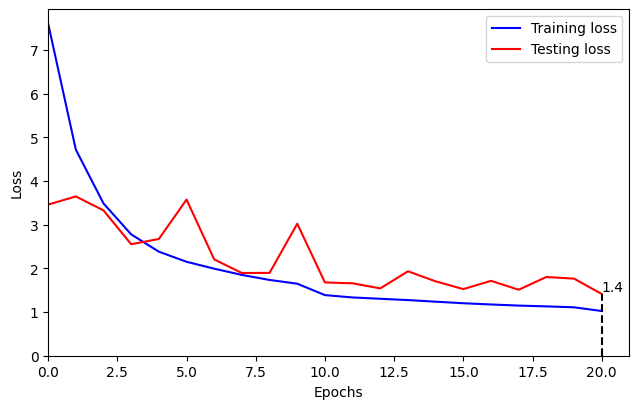

Traing epoch: 21   avg loss is: 1.0012544902604354
Testing epoch: 21   avg testing loss is: 1.3219124244009595
Testing on epoch: 21 has accuracy: top1: 86.15 top5: 97.76
Precision: 87.74%, Recall: 86.25%, F1 Score: 86.14%


/tmp/ipykernel_24/854556313.py:155: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/854556313.py:158: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


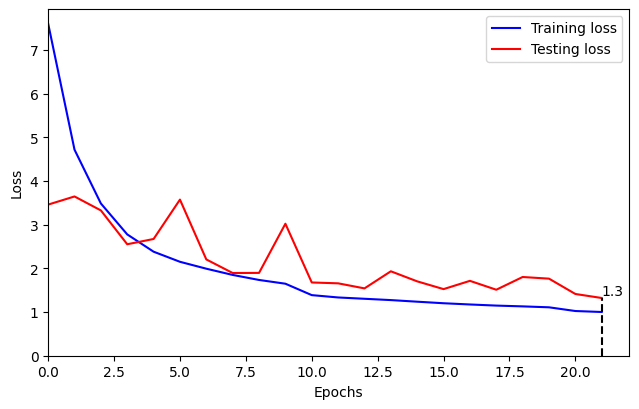

Traing epoch: 22   avg loss is: 0.9983607337673319
Testing epoch: 22   avg testing loss is: 1.3136810198008457
Testing on epoch: 22 has accuracy: top1: 86.46 top5: 97.62
Precision: 87.81%, Recall: 86.58%, F1 Score: 86.53%


/tmp/ipykernel_24/854556313.py:155: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/854556313.py:158: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


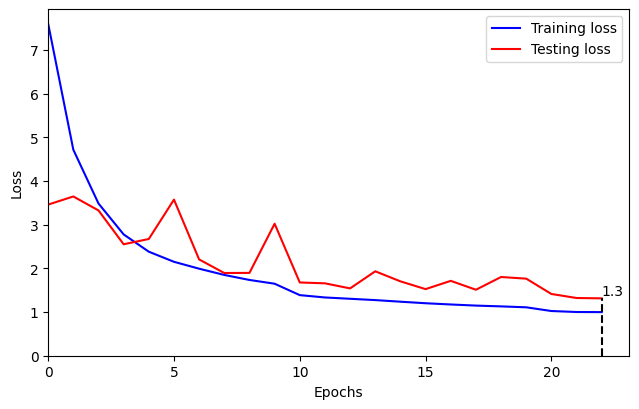

Traing epoch: 23   avg loss is: 0.9863756466291016
Testing epoch: 23   avg testing loss is: 1.310634217158285
Testing on epoch: 23 has accuracy: top1: 86.33 top5: 97.72
Precision: 88.01%, Recall: 86.41%, F1 Score: 86.34%


/tmp/ipykernel_24/854556313.py:155: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/854556313.py:158: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


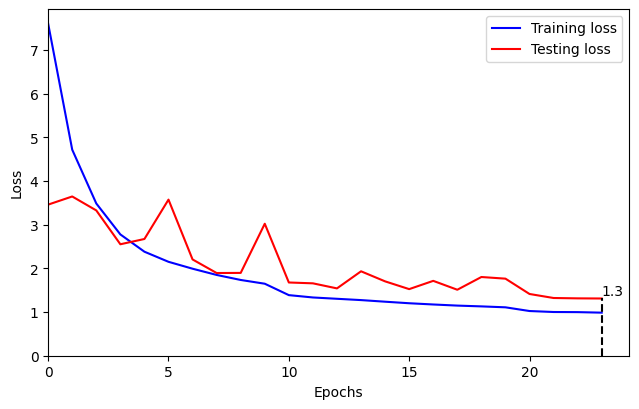

Traing epoch: 24   avg loss is: 0.9759630532996246
Testing epoch: 24   avg testing loss is: 1.4667942601943684
Testing on epoch: 24 has accuracy: top1: 81.14 top5: 96.29
Precision: 85.71%, Recall: 81.36%, F1 Score: 81.34%


/tmp/ipykernel_24/854556313.py:155: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/854556313.py:158: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


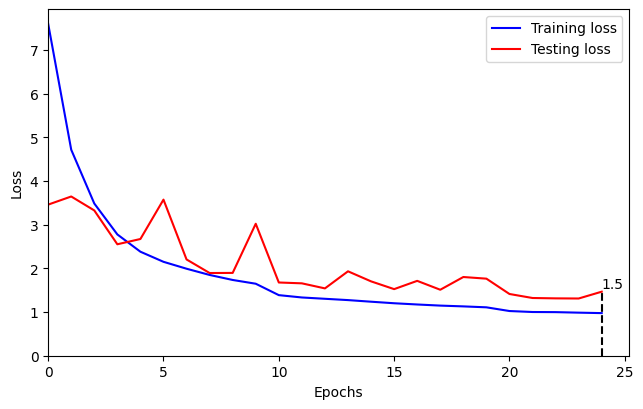

Traing epoch: 25   avg loss is: 0.9714618100531197
Testing epoch: 25   avg testing loss is: 1.3225682112286767
Testing on epoch: 25 has accuracy: top1: 85.47 top5: 97.91
Precision: 87.60%, Recall: 85.51%, F1 Score: 85.52%


/tmp/ipykernel_24/854556313.py:155: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/854556313.py:158: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


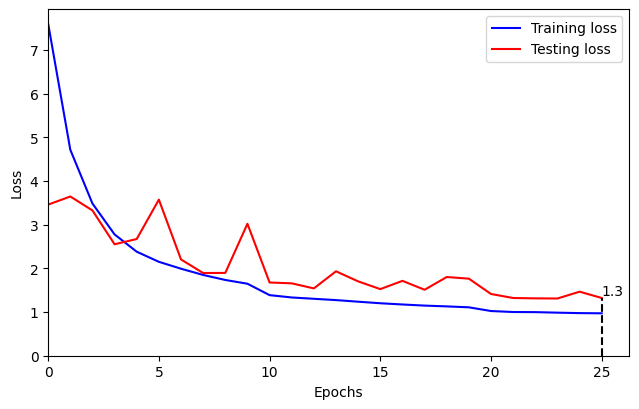

Traing epoch: 26   avg loss is: 0.9651324125625353
Testing epoch: 26   avg testing loss is: 1.3462896217066922
Testing on epoch: 26 has accuracy: top1: 84.42 top5: 97.62
Precision: 86.98%, Recall: 84.46%, F1 Score: 84.65%


/tmp/ipykernel_24/854556313.py:155: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/854556313.py:158: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


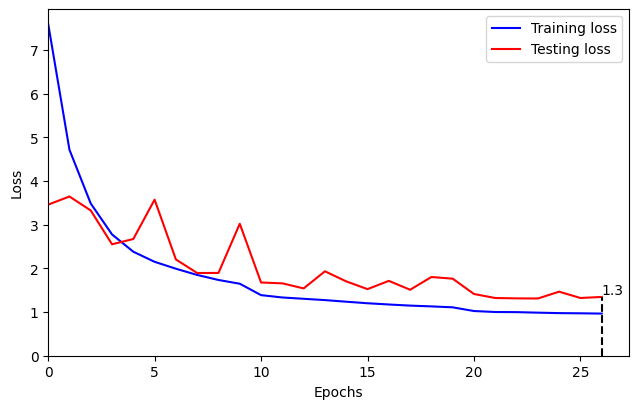

Traing epoch: 27   avg loss is: 0.9564516016877177
Testing epoch: 27   avg testing loss is: 1.3462866024807607
Testing on epoch: 27 has accuracy: top1: 84.55 top5: 97.21
Precision: 87.21%, Recall: 84.62%, F1 Score: 84.46%


/tmp/ipykernel_24/854556313.py:155: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/854556313.py:158: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


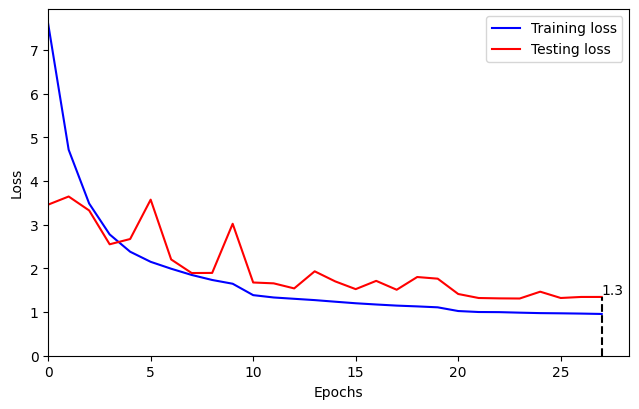

Traing epoch: 28   avg loss is: 0.9503330001215493
Testing epoch: 28   avg testing loss is: 1.3240232697899839
Testing on epoch: 28 has accuracy: top1: 85.68 top5: 97.66
Precision: 87.48%, Recall: 85.80%, F1 Score: 85.62%


/tmp/ipykernel_24/854556313.py:155: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/854556313.py:158: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


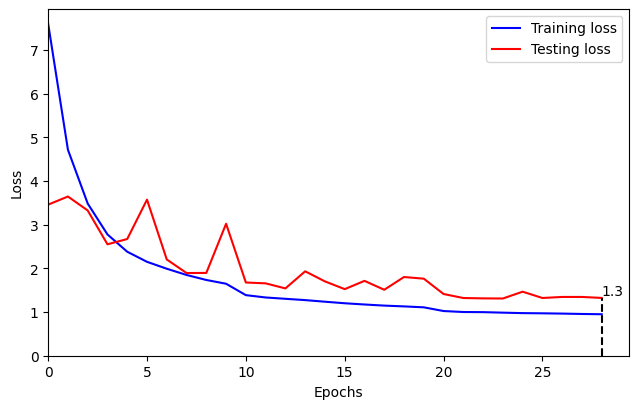

Traing epoch: 29   avg loss is: 0.943599528916201
Testing epoch: 29   avg testing loss is: 1.5059714982071397
Testing on epoch: 29 has accuracy: top1: 79.07 top5: 96.45
Precision: 85.07%, Recall: 79.24%, F1 Score: 79.67%


/tmp/ipykernel_24/854556313.py:155: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/854556313.py:158: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


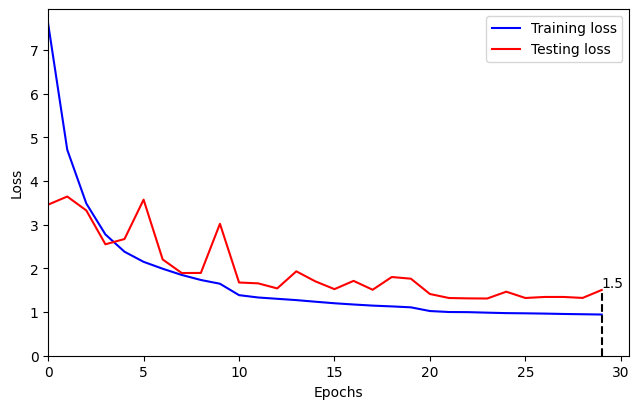

Traing epoch: 30   avg loss is: 0.9159398279645043
Testing epoch: 30   avg testing loss is: 1.3033657085115664
Testing on epoch: 30 has accuracy: top1: 86.72 top5: 97.68
Precision: 88.10%, Recall: 86.89%, F1 Score: 86.81%


/tmp/ipykernel_24/854556313.py:155: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/854556313.py:158: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


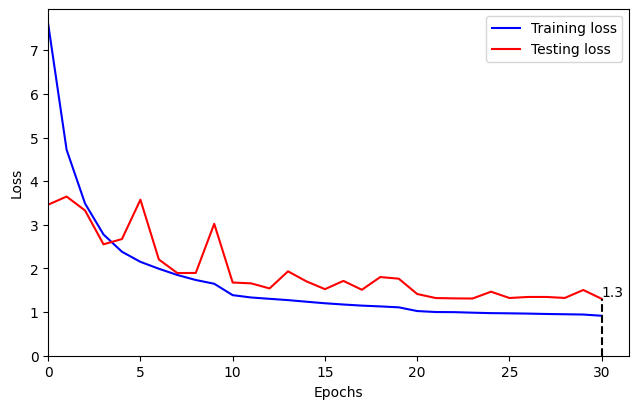

Traing epoch: 31   avg loss is: 0.9096415119822389
Testing epoch: 31   avg testing loss is: 1.3340007408385708
Testing on epoch: 31 has accuracy: top1: 85.70 top5: 97.56
Precision: 88.07%, Recall: 85.74%, F1 Score: 85.80%


/tmp/ipykernel_24/854556313.py:155: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/854556313.py:158: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


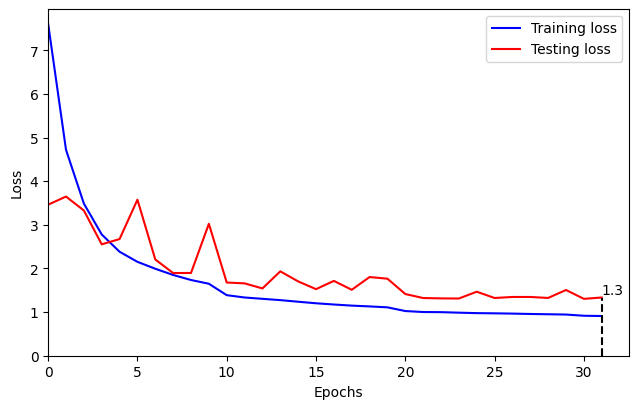

Traing epoch: 32   avg loss is: 0.9079819806164062
Testing epoch: 32   avg testing loss is: 1.3307046327635506
Testing on epoch: 32 has accuracy: top1: 85.16 top5: 97.35
Precision: 87.14%, Recall: 85.39%, F1 Score: 85.25%


/tmp/ipykernel_24/854556313.py:155: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/854556313.py:158: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


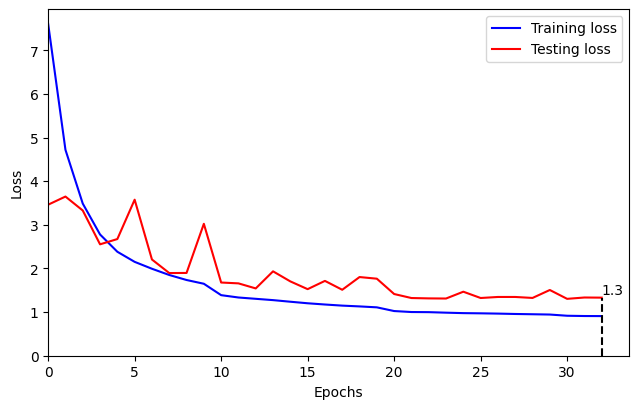

Traing epoch: 33   avg loss is: 0.9028599132322841
Testing epoch: 33   avg testing loss is: 1.2619443535804749
Testing on epoch: 33 has accuracy: top1: 87.99 top5: 98.09
Precision: 89.01%, Recall: 88.12%, F1 Score: 87.96%


/tmp/ipykernel_24/854556313.py:155: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/854556313.py:158: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


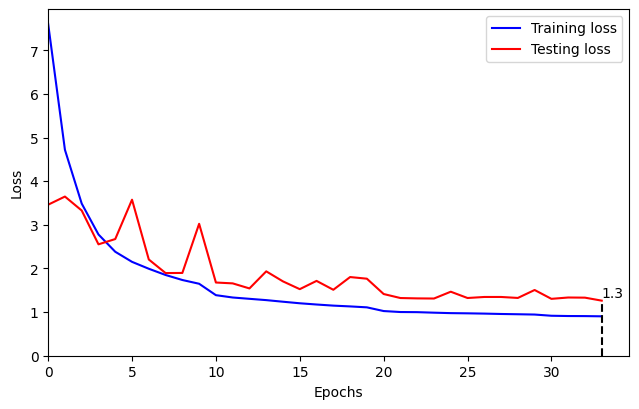

Traing epoch: 34   avg loss is: 0.9025967504177503
Testing epoch: 34   avg testing loss is: 1.2917693948077265
Testing on epoch: 34 has accuracy: top1: 86.99 top5: 97.70
Precision: 88.27%, Recall: 87.10%, F1 Score: 87.01%


/tmp/ipykernel_24/854556313.py:155: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/854556313.py:158: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


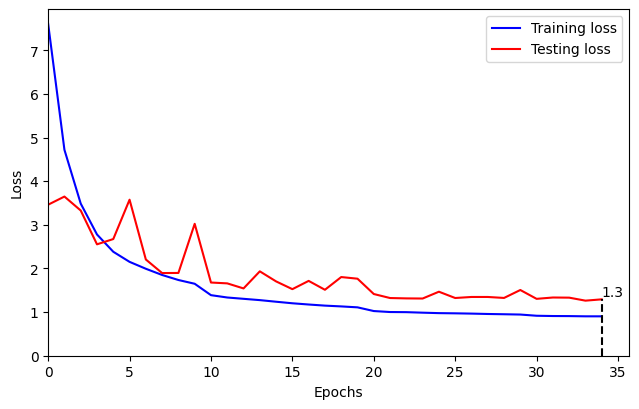

Traing epoch: 35   avg loss is: 0.8975412158123013
Testing epoch: 35   avg testing loss is: 1.2841111261896627
Testing on epoch: 35 has accuracy: top1: 87.83 top5: 97.95
Precision: 89.30%, Recall: 87.94%, F1 Score: 87.85%


/tmp/ipykernel_24/854556313.py:155: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/854556313.py:158: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


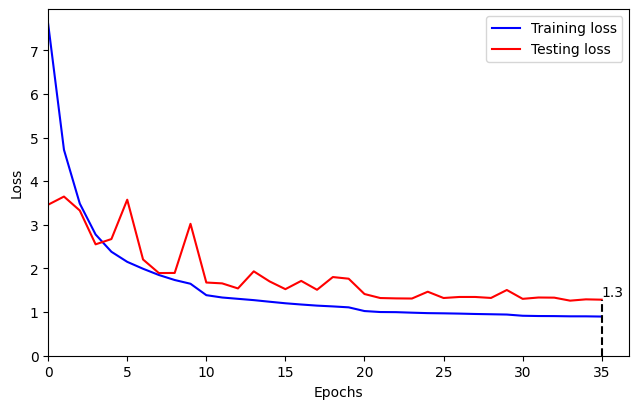

Traing epoch: 36   avg loss is: 0.8954183287549174
Testing epoch: 36   avg testing loss is: 1.2628127696729523
Testing on epoch: 36 has accuracy: top1: 88.24 top5: 97.93
Precision: 89.56%, Recall: 88.30%, F1 Score: 88.23%


/tmp/ipykernel_24/854556313.py:155: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/854556313.py:158: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


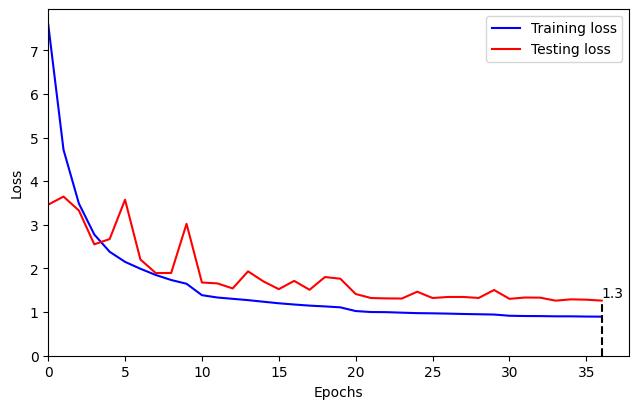

Traing epoch: 37   avg loss is: 0.8920920711460238
Testing epoch: 37   avg testing loss is: 1.2848765252163847
Testing on epoch: 37 has accuracy: top1: 87.32 top5: 97.91
Precision: 88.84%, Recall: 87.45%, F1 Score: 87.32%


/tmp/ipykernel_24/854556313.py:155: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/854556313.py:158: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


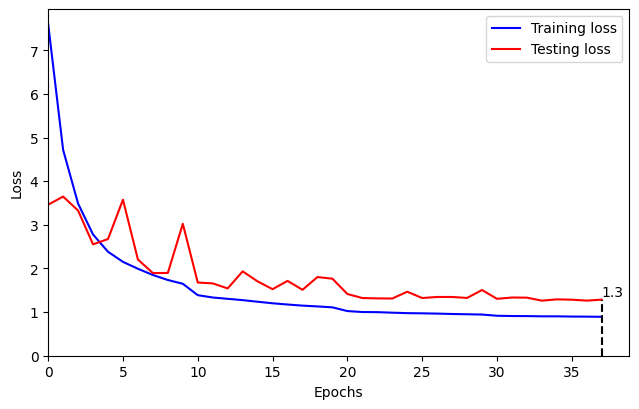

Traing epoch: 38   avg loss is: 0.8905528590877665
Testing epoch: 38   avg testing loss is: 1.2564648952439568
Testing on epoch: 38 has accuracy: top1: 88.00 top5: 98.13
Precision: 89.24%, Recall: 88.10%, F1 Score: 88.03%


/tmp/ipykernel_24/854556313.py:155: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/854556313.py:158: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


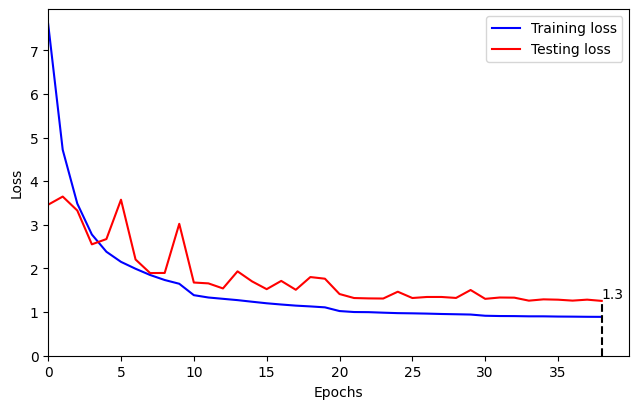

Traing epoch: 39   avg loss is: 0.8867630753927526
Testing epoch: 39   avg testing loss is: 1.2394325278258398
Testing on epoch: 39 has accuracy: top1: 88.30 top5: 98.11
Precision: 89.27%, Recall: 88.41%, F1 Score: 88.26%


/tmp/ipykernel_24/854556313.py:155: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/854556313.py:158: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


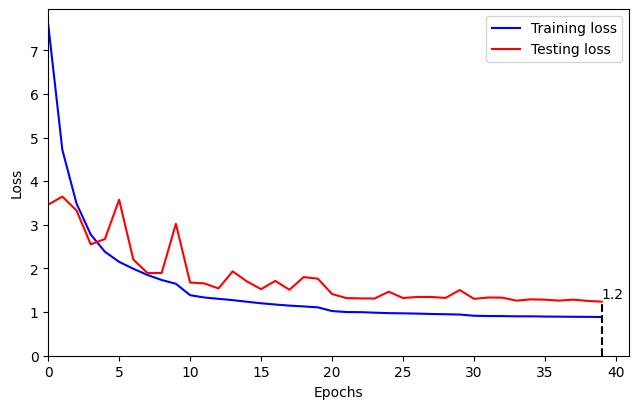

Traing epoch: 40   avg loss is: 0.8773299098795435
Testing epoch: 40   avg testing loss is: 1.2757509848410467
Testing on epoch: 40 has accuracy: top1: 87.52 top5: 98.01
Precision: 88.86%, Recall: 87.60%, F1 Score: 87.46%


/tmp/ipykernel_24/854556313.py:155: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/854556313.py:158: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


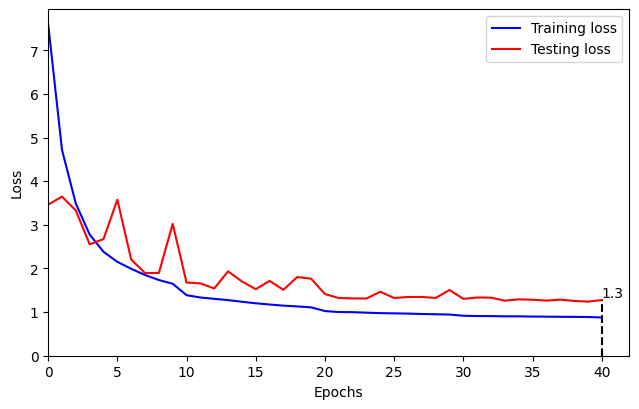

Traing epoch: 41   avg loss is: 0.8750538435687073
Testing epoch: 41   avg testing loss is: 1.2990715344004171
Testing on epoch: 41 has accuracy: top1: 86.60 top5: 97.72
Precision: 88.24%, Recall: 86.75%, F1 Score: 86.65%


/tmp/ipykernel_24/854556313.py:155: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/854556313.py:158: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


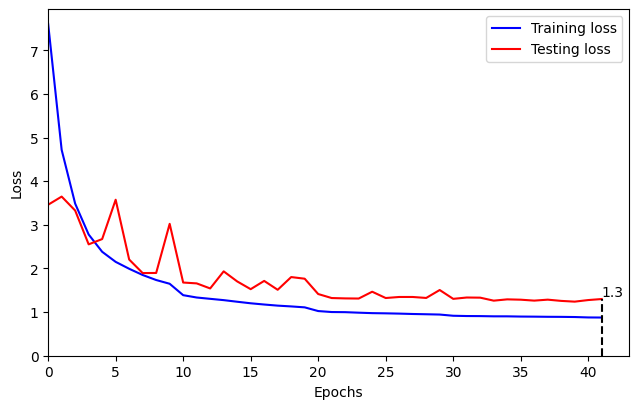

Traing epoch: 42   avg loss is: 0.8731232512989704
Testing epoch: 42   avg testing loss is: 1.2501753960443063
Testing on epoch: 42 has accuracy: top1: 88.47 top5: 98.24
Precision: 89.43%, Recall: 88.61%, F1 Score: 88.47%


/tmp/ipykernel_24/854556313.py:155: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/854556313.py:158: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


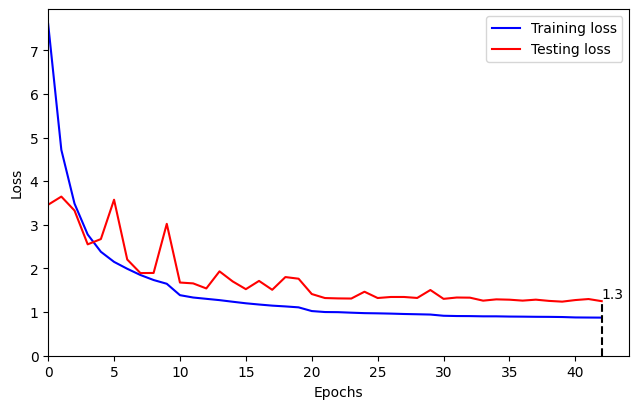

Traing epoch: 43   avg loss is: 0.8729477601702577
Testing epoch: 43   avg testing loss is: 1.2661400671317198
Testing on epoch: 43 has accuracy: top1: 88.43 top5: 98.03
Precision: 89.23%, Recall: 88.59%, F1 Score: 88.44%


/tmp/ipykernel_24/854556313.py:155: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/854556313.py:158: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


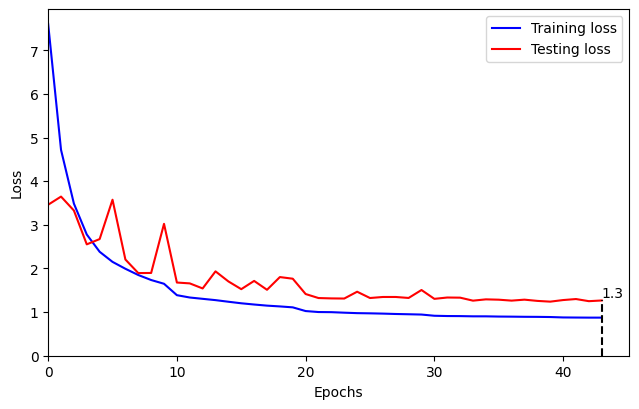

Traing epoch: 44   avg loss is: 0.8715043061798816
Testing epoch: 44   avg testing loss is: 1.249013953862532
Testing on epoch: 44 has accuracy: top1: 88.63 top5: 98.13
Precision: 89.67%, Recall: 88.67%, F1 Score: 88.59%


/tmp/ipykernel_24/854556313.py:155: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/854556313.py:158: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


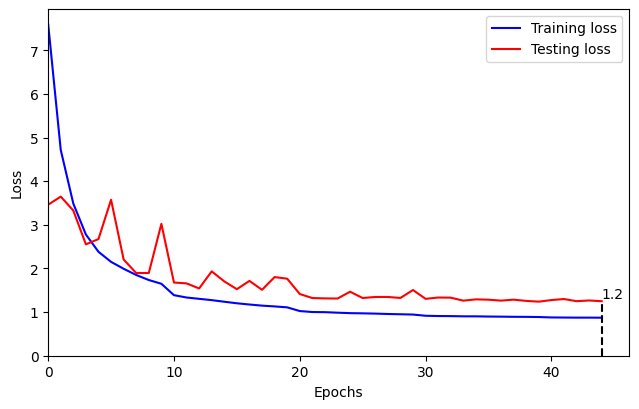

Traing epoch: 45   avg loss is: 0.8703029451802916
Testing epoch: 45   avg testing loss is: 1.2485973671589314
Testing on epoch: 45 has accuracy: top1: 88.82 top5: 98.09
Precision: 89.77%, Recall: 88.88%, F1 Score: 88.79%


/tmp/ipykernel_24/854556313.py:155: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/854556313.py:158: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


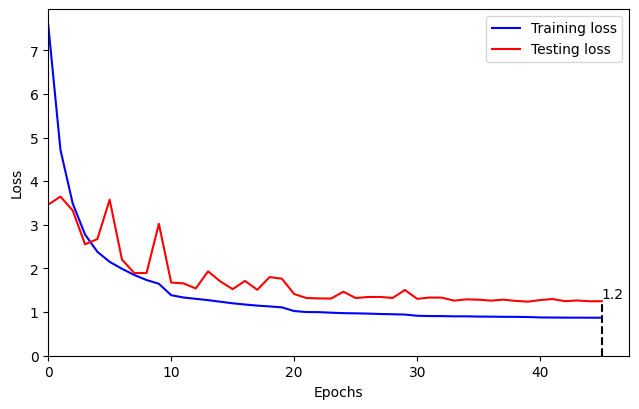

Traing epoch: 46   avg loss is: 0.8683427436759921
Testing epoch: 46   avg testing loss is: 1.2282692251547103
Testing on epoch: 46 has accuracy: top1: 89.12 top5: 98.23
Precision: 90.22%, Recall: 89.15%, F1 Score: 89.16%


/tmp/ipykernel_24/854556313.py:155: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/854556313.py:158: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


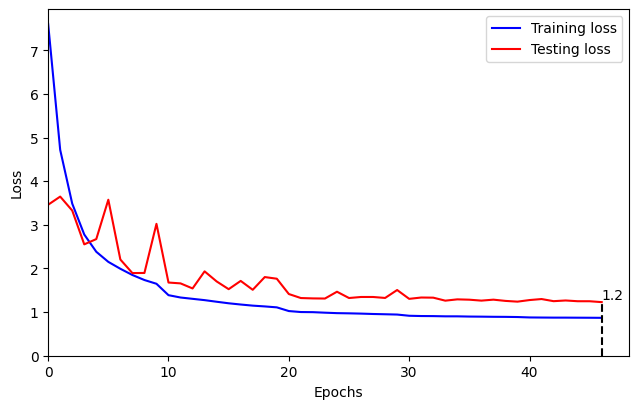

Traing epoch: 47   avg loss is: 0.8678954847512454
Testing epoch: 47   avg testing loss is: 1.2455303288323114
Testing on epoch: 47 has accuracy: top1: 89.08 top5: 98.24
Precision: 89.90%, Recall: 89.12%, F1 Score: 89.02%


/tmp/ipykernel_24/854556313.py:155: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/854556313.py:158: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


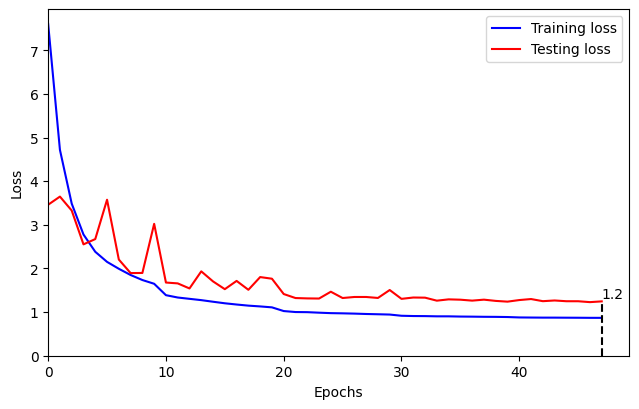

Traing epoch: 48   avg loss is: 0.8660595485046715
Testing epoch: 48   avg testing loss is: 1.2366820068745599
Testing on epoch: 48 has accuracy: top1: 89.49 top5: 98.03
Precision: 90.45%, Recall: 89.53%, F1 Score: 89.44%


/tmp/ipykernel_24/854556313.py:155: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/854556313.py:158: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


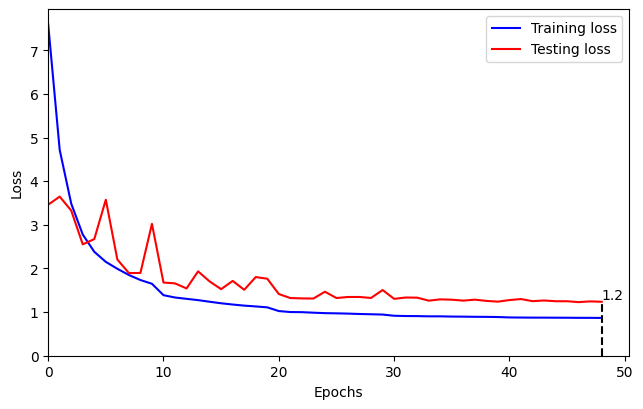

Traing epoch: 49   avg loss is: 0.8666347343861444
Testing epoch: 49   avg testing loss is: 1.2347156399878385
Testing on epoch: 49 has accuracy: top1: 88.98 top5: 98.30
Precision: 89.97%, Recall: 89.04%, F1 Score: 89.03%


/tmp/ipykernel_24/854556313.py:155: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/854556313.py:158: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


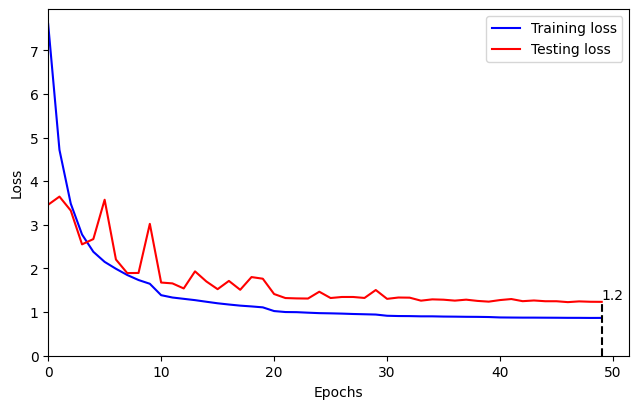

Traing epoch: 50   avg loss is: 0.8617318979036708
Testing epoch: 50   avg testing loss is: 1.2436820764407934
Testing on epoch: 50 has accuracy: top1: 88.86 top5: 98.11
Precision: 89.76%, Recall: 88.94%, F1 Score: 88.84%


/tmp/ipykernel_24/854556313.py:155: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/854556313.py:158: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


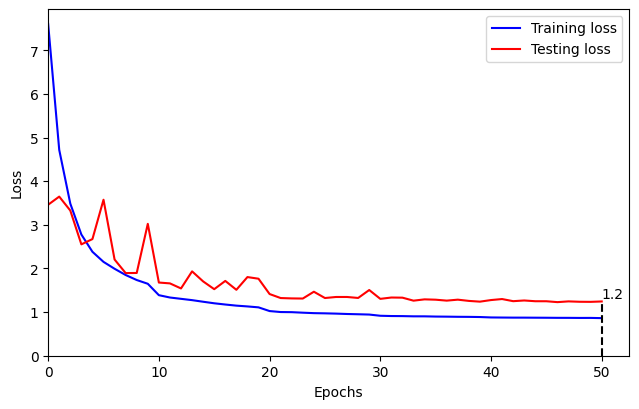

Traing epoch: 51   avg loss is: 0.8606002200307747
Testing epoch: 51   avg testing loss is: 1.255413086429192
Testing on epoch: 51 has accuracy: top1: 88.84 top5: 98.17
Precision: 89.83%, Recall: 88.90%, F1 Score: 88.85%


/tmp/ipykernel_24/854556313.py:155: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/854556313.py:158: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


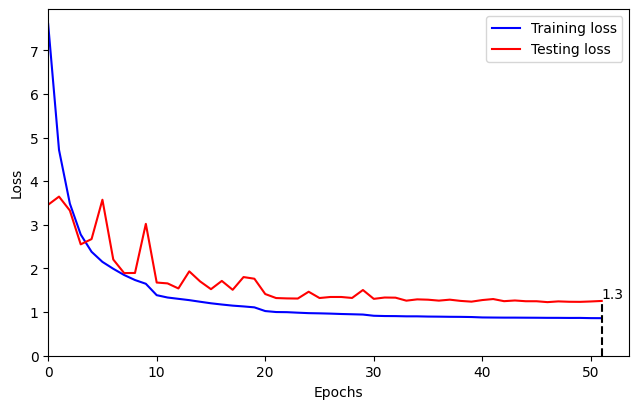

Traing epoch: 52   avg loss is: 0.8589607701332799
Testing epoch: 52   avg testing loss is: 1.2286348924087216
Testing on epoch: 52 has accuracy: top1: 89.39 top5: 98.30
Precision: 90.39%, Recall: 89.39%, F1 Score: 89.39%


/tmp/ipykernel_24/854556313.py:155: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/854556313.py:158: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


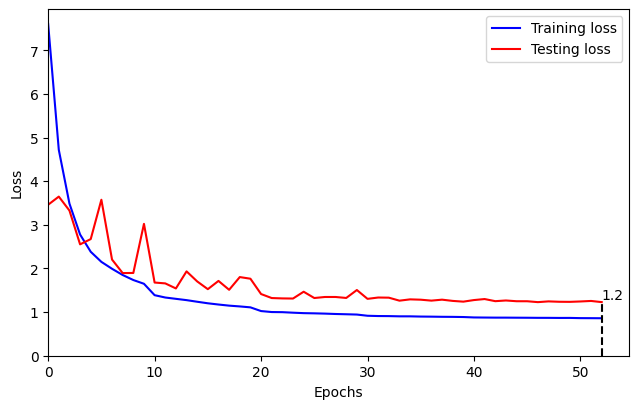

Traing epoch: 53   avg loss is: 0.8601846491989407
Testing epoch: 53   avg testing loss is: 1.2364894664176156
Testing on epoch: 53 has accuracy: top1: 89.72 top5: 98.28
Precision: 90.50%, Recall: 89.73%, F1 Score: 89.68%


/tmp/ipykernel_24/854556313.py:155: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/854556313.py:158: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


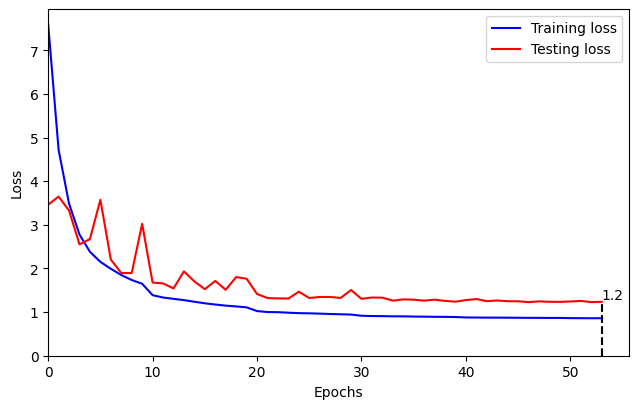

Traing epoch: 54   avg loss is: 0.8580506912339392
Testing epoch: 54   avg testing loss is: 1.2338446737078492
Testing on epoch: 54 has accuracy: top1: 89.51 top5: 98.23
Precision: 90.25%, Recall: 89.54%, F1 Score: 89.45%


/tmp/ipykernel_24/854556313.py:155: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/854556313.py:158: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


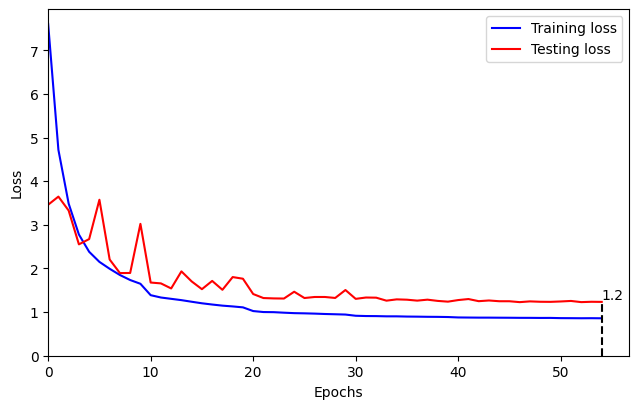

Traing epoch: 55   avg loss is: 0.8588186529777784
Testing epoch: 55   avg testing loss is: 1.2470646134789487
Testing on epoch: 55 has accuracy: top1: 89.35 top5: 98.11
Precision: 90.09%, Recall: 89.42%, F1 Score: 89.30%


/tmp/ipykernel_24/854556313.py:155: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/854556313.py:158: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


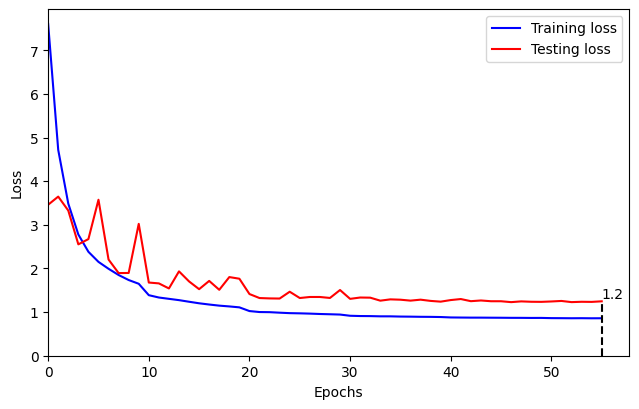

Traing epoch: 56   avg loss is: 0.8577153679363297
Testing epoch: 56   avg testing loss is: 1.2569430971814093
Testing on epoch: 56 has accuracy: top1: 88.78 top5: 98.03
Precision: 89.64%, Recall: 88.80%, F1 Score: 88.71%


/tmp/ipykernel_24/854556313.py:155: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/854556313.py:158: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


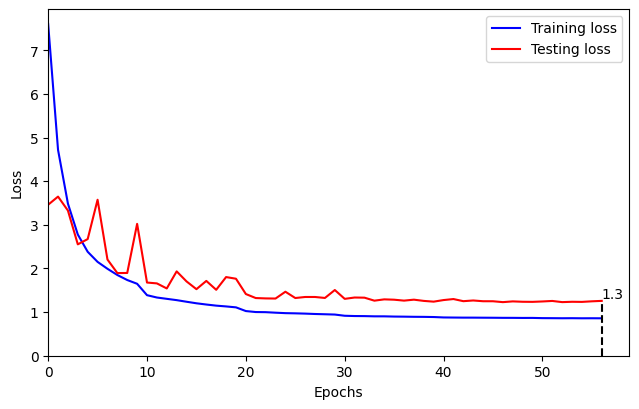

Traing epoch: 57   avg loss is: 0.8576027154922485
Testing epoch: 57   avg testing loss is: 1.240426625418143
Testing on epoch: 57 has accuracy: top1: 88.94 top5: 98.32
Precision: 89.71%, Recall: 88.99%, F1 Score: 88.85%


/tmp/ipykernel_24/854556313.py:155: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/854556313.py:158: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


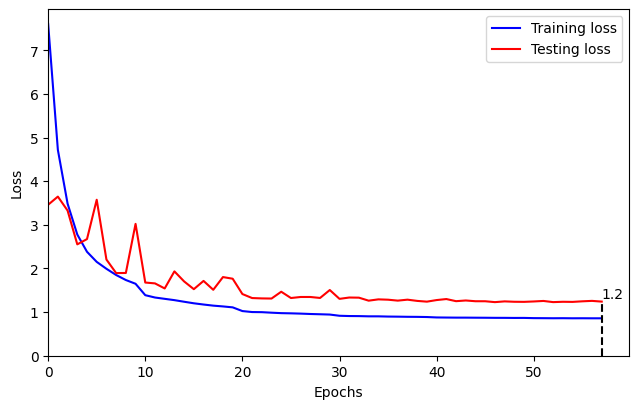

Traing epoch: 58   avg loss is: 0.8563603801187564
Testing epoch: 58   avg testing loss is: 1.2506834675218457
Testing on epoch: 58 has accuracy: top1: 89.27 top5: 98.17
Precision: 90.15%, Recall: 89.31%, F1 Score: 89.26%


/tmp/ipykernel_24/854556313.py:155: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/854556313.py:158: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


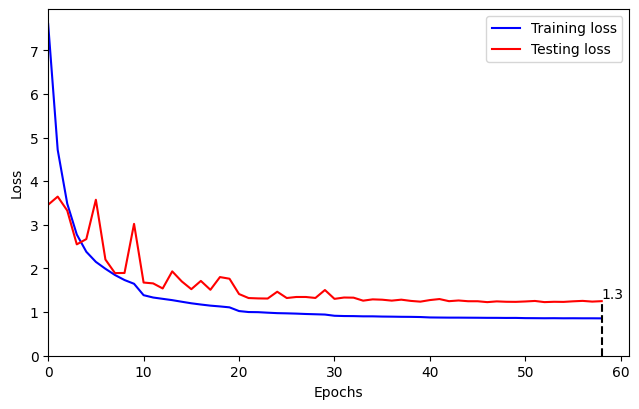

Traing epoch: 59   avg loss is: 0.8570098457100015
Testing epoch: 59   avg testing loss is: 1.222969322746788
Testing on epoch: 59 has accuracy: top1: 89.74 top5: 98.24
Precision: 90.38%, Recall: 89.80%, F1 Score: 89.69%


/tmp/ipykernel_24/854556313.py:155: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/854556313.py:158: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


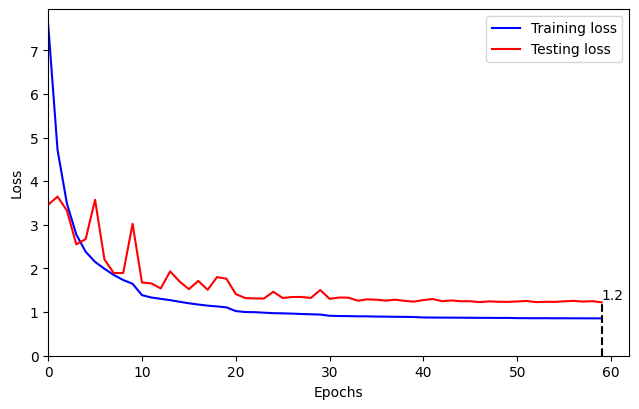

Traing epoch: 60   avg loss is: 0.8540285870892852
Testing epoch: 60   avg testing loss is: 1.2404707673925477
Testing on epoch: 60 has accuracy: top1: 89.47 top5: 98.34
Precision: 90.18%, Recall: 89.50%, F1 Score: 89.42%


/tmp/ipykernel_24/854556313.py:155: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/854556313.py:158: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


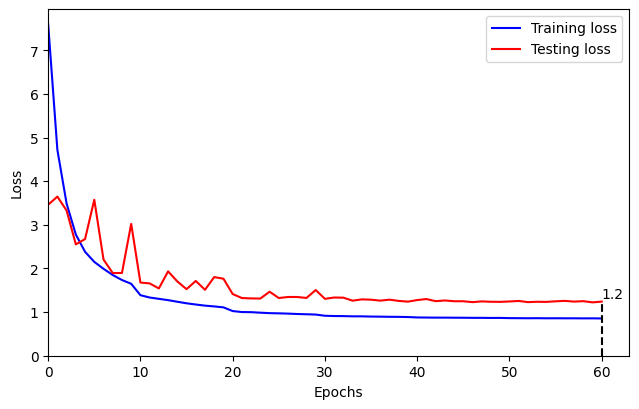

Traing epoch: 61   avg loss is: 0.8538101500055297
Testing epoch: 61   avg testing loss is: 1.2479938042126713
Testing on epoch: 61 has accuracy: top1: 89.17 top5: 98.19
Precision: 89.96%, Recall: 89.21%, F1 Score: 89.11%


/tmp/ipykernel_24/854556313.py:155: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/854556313.py:158: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


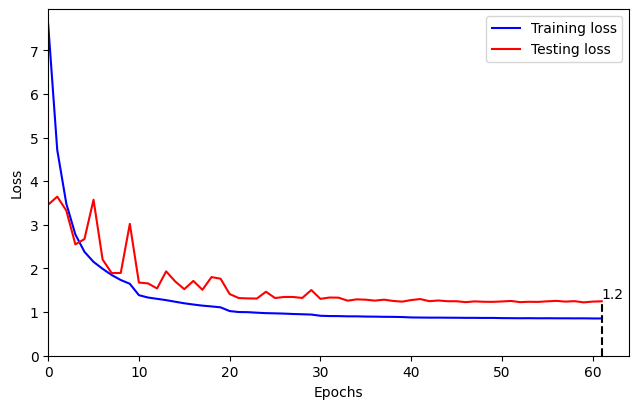

Traing epoch: 62   avg loss is: 0.8529564109330315
Testing epoch: 62   avg testing loss is: 1.2358833560691074
Testing on epoch: 62 has accuracy: top1: 89.55 top5: 98.23
Precision: 90.30%, Recall: 89.60%, F1 Score: 89.47%


/tmp/ipykernel_24/854556313.py:155: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/854556313.py:158: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


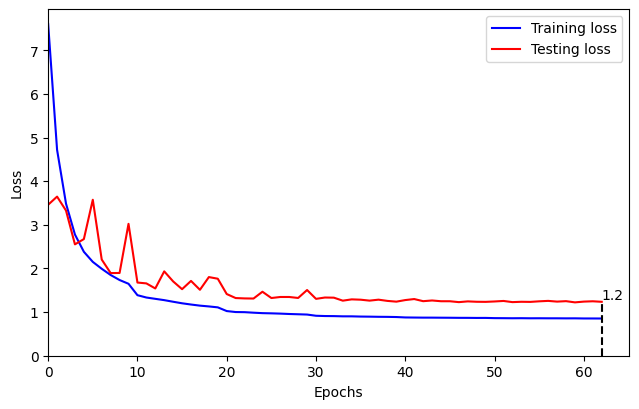

Traing epoch: 63   avg loss is: 0.8520938216022959
Testing epoch: 63   avg testing loss is: 1.230300119918455
Testing on epoch: 63 has accuracy: top1: 89.47 top5: 98.30
Precision: 90.28%, Recall: 89.51%, F1 Score: 89.46%


/tmp/ipykernel_24/854556313.py:155: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/854556313.py:158: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


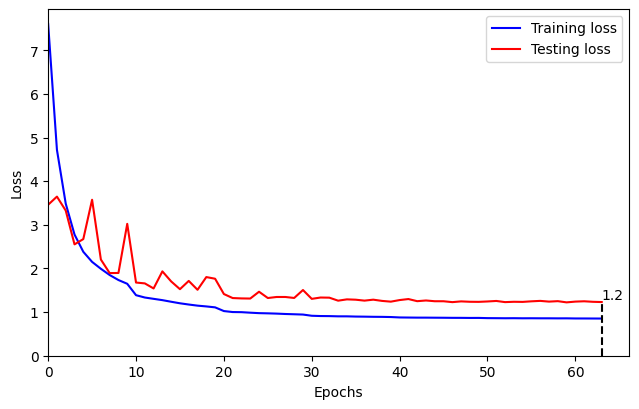

Traing epoch: 64   avg loss is: 0.8528228749506266
Testing epoch: 64   avg testing loss is: 1.2345855321468222
Testing on epoch: 64 has accuracy: top1: 89.43 top5: 98.30
Precision: 90.17%, Recall: 89.45%, F1 Score: 89.37%


/tmp/ipykernel_24/854556313.py:155: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/854556313.py:158: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


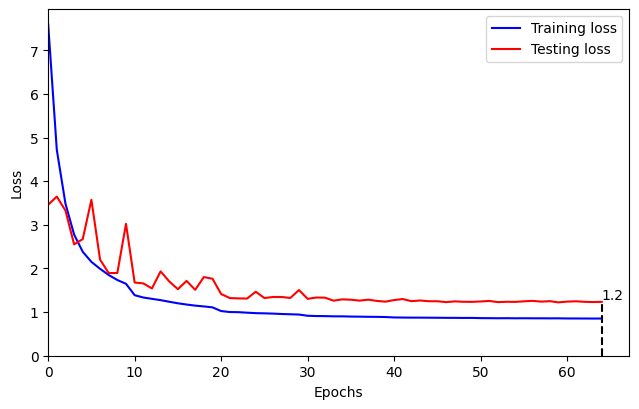

Traing epoch: 65   avg loss is: 0.8522645620345177
Testing epoch: 65   avg testing loss is: 1.2625012286355561
Testing on epoch: 65 has accuracy: top1: 88.30 top5: 98.03
Precision: 89.28%, Recall: 88.35%, F1 Score: 88.26%


/tmp/ipykernel_24/854556313.py:155: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/854556313.py:158: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


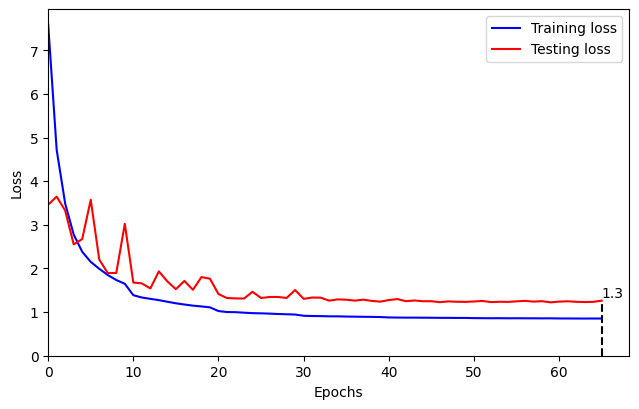

Traing epoch: 66   avg loss is: 0.8526369679520573
Testing epoch: 66   avg testing loss is: 1.2518410396724475
Testing on epoch: 66 has accuracy: top1: 88.98 top5: 98.05
Precision: 89.79%, Recall: 89.02%, F1 Score: 88.88%


/tmp/ipykernel_24/854556313.py:155: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/854556313.py:158: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


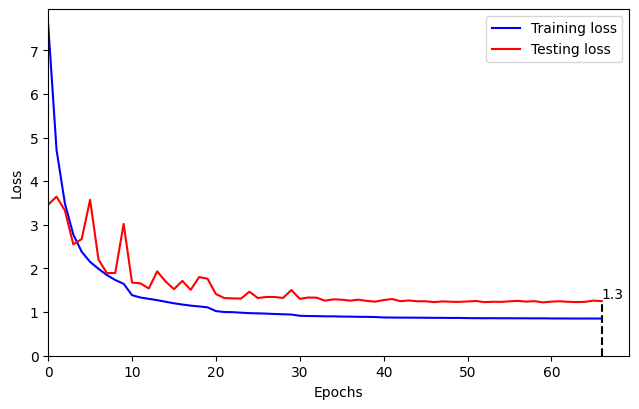

Traing epoch: 67   avg loss is: 0.8515172103947852
Testing epoch: 67   avg testing loss is: 1.2705847275591342
Testing on epoch: 67 has accuracy: top1: 88.67 top5: 97.97
Precision: 89.49%, Recall: 88.76%, F1 Score: 88.64%


/tmp/ipykernel_24/854556313.py:155: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/854556313.py:158: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


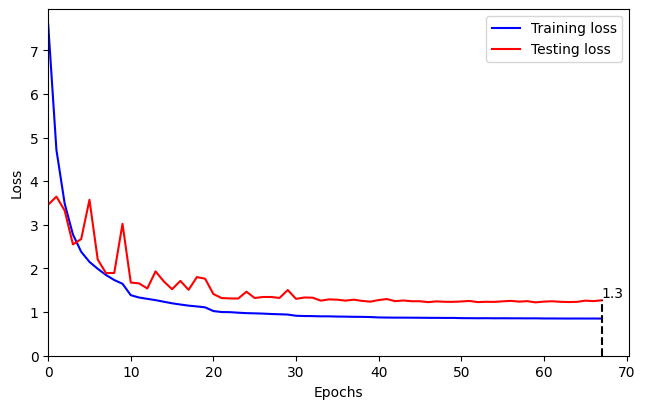

Traing epoch: 68   avg loss is: 0.8512466101026401
Testing epoch: 68   avg testing loss is: 1.2261083562426107
Testing on epoch: 68 has accuracy: top1: 89.57 top5: 98.23
Precision: 90.31%, Recall: 89.60%, F1 Score: 89.55%


/tmp/ipykernel_24/854556313.py:155: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/854556313.py:158: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


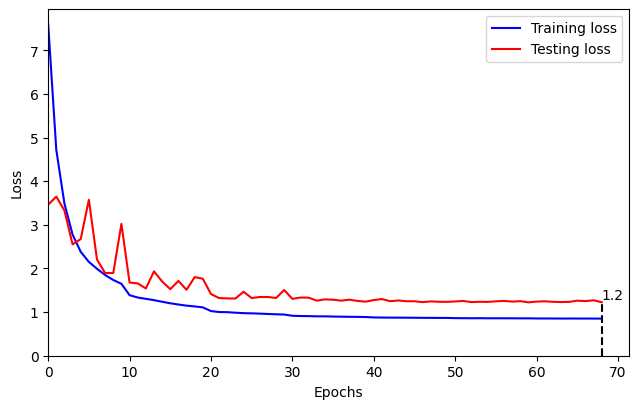

Traing epoch: 69   avg loss is: 0.8517255431251954
Testing epoch: 69   avg testing loss is: 1.242045287773988
Testing on epoch: 69 has accuracy: top1: 89.43 top5: 98.34
Precision: 90.21%, Recall: 89.48%, F1 Score: 89.37%


/tmp/ipykernel_24/854556313.py:155: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/854556313.py:158: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


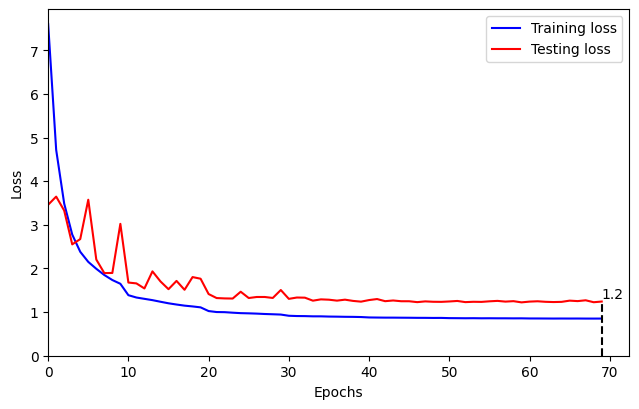

In [ ]:
class DeepWriter_Train:
    def __init__(self,dataset='CERUG-EN',imgtype='png',mode='vertical'):

        self.dataset = dataset
        self.folder = dataset
        #self.labelfolder = 'dataset/'

        if not os.path.exists(self.folder):
            if dataset == 'CERUG-EN':
                pass
                #download_cerug(dataset)
            elif dataset == 'Firemaker':
                download_firemaker(dataset)
            else:
                print('****** Warning: the dataset %s does not existed!******'%dataset)
                print('Please go to the following website to check how to download the dataset:')
                print('https://www.ai.rug.nl/~sheng/writeridataset.html')
                print('*'*20)
                raise ValueError('Dataset: %s does not existed!'%dataset)

        self.labelfolder = self.folder
        #self.train_folder = self.folder+'/train/'

        source_folder = '/kaggle/input/cerug-en/CERUG-EN-train-images/'
        destination_folder = '/kaggle/working/'

        # Copy the contents
        copy_folder_contents(source_folder, destination_folder)

        self.train_folder = destination_folder+'/train/'

        transformer = ImageTransformer(foldername=self.train_folder)
        transformer.process_and_save_images()

        #self.test_folder = self.folder+'/test/'
        self.test_folder = '/kaggle/input/cerug-en/CERUG-EN-test-images/test/'

        self.imgtype=imgtype
        self.mode = mode
        self.device = 'cuda'
        self.scale_size=(64,128)

        if self.device == 'cuda':
            torch.backends.cudnn.benchmark = True

        if self.dataset == 'CVL':
            self.imgtype = 'tif'

        self.model_dir = 'model'
        if not os.path.exists(self.model_dir):
            #raise ValueError('Model directory: %s does not existed'%self.model_dir)
            os.mkdir(self.model_dir)#raise ValueError('Model directory: %s does not existed'%self.model_dir)

        basedir = 'GRRNN_WriterIdentification_dataset_'+self.dataset+'_model_'+self.mode+'_aug_16'
        self.logfile= basedir + '.log'
        self.modelfile = basedir
        self.batch_size = 16

        train_set = DatasetFromFolder(dataset=self.dataset,
        				labelfolder = self.labelfolder,
                        foldername=self.train_folder,
                        imgtype=self.imgtype,
                        scale_size=self.scale_size,
                        is_training = True)

        self.training_data_loader = DataLoader(dataset=train_set, num_workers=0,
                           batch_size=self.batch_size, shuffle=True, drop_last=True)

        test_set = DatasetFromFolder(dataset=self.dataset,
        				labelfolder = self.labelfolder,
                        foldername=self.test_folder,imgtype=self.imgtype,
                        scale_size=self.scale_size,
                        is_training = False)

        self.testing_data_loader = DataLoader(dataset=test_set, num_workers=0,
                           batch_size=self.batch_size, shuffle=False)

        num_class = train_set.num_writer
        self.model = GrnnNet(1,num_classes=train_set.num_writer).to(self.device)

        #self.criterion = nn.CrossEntropyLoss()
        self.criterion = LabelSomCE()
        self.optimizer = optim.Adam(self.model.parameters(),lr=0.0001,weight_decay=1e-4)
        self.scheduler = lr_scheduler.StepLR(self.optimizer,step_size=10,gamma=0.5)

    def train(self,epoch):
        self.model.train()
        losstotal = []

        total_batches = len(self.training_data_loader)

        for iteration,batch in enumerate(self.training_data_loader,1):
            inputs = batch[0].to(self.device).float()
            target = batch[1].type(torch.long).to(self.device)


            self.optimizer.zero_grad()

            logits = self.model(inputs)

            train_loss= self.criterion(logits,target)

            losstotal.append(train_loss.item())
            train_loss.backward()
            self.optimizer.step()


        with open(self.logfile,'a') as fp:
            fp.write('Training epoch %d avg loss is: %.6f\n'%(epoch,np.mean(losstotal)))
        print('Traing epoch:',epoch,'  avg loss is:',np.mean(losstotal))
        return np.mean(losstotal)


    def test(self,epoch,during_train=True):
        self.model.eval()
        losstotal = []

        if not during_train:
            self.load_model(epoch)

        top1 = 0
        top5 = 0
        ntotal=0

        all_preds = []
        all_targets = []

        for iteration,batch in enumerate(self.testing_data_loader,1):
            inputs = batch[0].to(self.device).float()
            target = batch[1].to(self.device).long()

            logits = self.model(inputs)

            test_loss = self.criterion(logits,target)

            losstotal.append(test_loss.item())

            res = self.accuracy(logits,target,topk=(1,5))
            top1 += res[0]
            top5 += res[1]

            ntotal += inputs.size(0)

            _, preds = logits.topk(1, 1, True, True)
            all_preds.extend(preds.cpu().numpy().flatten())
            all_targets.extend(target.cpu().numpy().flatten())


        top1 /= float(ntotal)
        top5 /= float(ntotal)

        precision, recall, f1 = self.compute_metrics(all_preds, all_targets)

        print('Testing epoch:',epoch,'  avg testing loss is:',np.mean(losstotal))
        print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
        print('Precision: %.2f%%, Recall: %.2f%%, F1 Score: %.2f%%' % (precision * 100, recall * 100, f1 * 100))
        with open(self.logfile,'a') as fp:
            fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))

        return np.mean(losstotal)

    def check_exists(self,epoch):
        model_out_path = self.model_dir + '/' + self.modelfile + '-model_epoch_{}.pth'.format(epoch)
        return os.path.exists(model_out_path)

    def checkpoint(self,epoch):
        model_out_path = self.model_dir + '/' + self.modelfile + '-model_epoch_{}.pth'.format(epoch)
        torch.save(self.model.state_dict(),model_out_path)


    def load_model(self,epoch):
        model_out_path = self.model_dir + '/' + self.modelfile + '-model_epoch_{}.pth'.format(epoch)
        self.model.load_state_dict(torch.load(model_out_path,map_location=self.device))
        print('Load model successful')


    def plot_losses(self, training_losses, testing_losses):
        indices = range(len(training_losses))
        plt.figure(figsize=(7.5, 4.5))
        plt.plot(indices, training_losses, 'b', label='Training loss')
        plt.plot(indices, testing_losses, 'r', label='Testing loss')
        #plt.title('Training and Testing Losses')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.xlim(left=0)
        plt.ylim(bottom=0)

        last_epoch = indices[-1]
        last_test_loss = testing_losses[-1]
        plt.plot([last_epoch, last_epoch], [0, last_test_loss], 'k--')
        plt.text(last_epoch, last_test_loss, f'{last_test_loss:.1f}', color='k', va='bottom', ha='left')
        plt.savefig("/kaggle/working/loss_plot.svg", format="svg", dpi=300)


        plt.show()


    def train_loops(self,start_epoch,num_epoch):
        #if self.check_exists(num_epoch): return
        if start_epoch > 0:
            self.load_model(start_epoch-1)

        training_losses = []
        testing_losses = []

        for epoch in range(start_epoch,num_epoch):

            train_loss = self.train(epoch)
            training_losses.append(train_loss)
            self.checkpoint(epoch)
            test_loss = self.test(epoch)
            testing_losses.append(test_loss)
            self.scheduler.step()
            self.plot_losses(training_losses, testing_losses)


    def accuracy(self,output,target,topk=(1,)):
        with torch.no_grad():
            maxk = max(topk)
            _,pred = output.topk(maxk,1,True,True)
            pred = pred.t()
            correct = pred.eq(target.view(1, -1).expand_as(pred))

            res = []
            for k in topk:
                correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
                res.append(correct_k.data.cpu().numpy())

        return res

    def compute_metrics(self, preds, targets):
        precision, recall, f1, _ = precision_recall_fscore_support(targets, preds, average='macro')
        return precision, recall, f1


if __name__ == '__main__':

    modelist = ['vertical','horizontal']
    mode = modelist[1]

    mod = DeepWriter_Train(dataset='CERUG-EN',mode=mode)
    mod.train_loops(0,70)